# IE-7500 - Applied Natural Language Processing - (Spring 2025)
## Sentiment Analysis for Food Reviews using Yelp® Review Dataset 

### Team Members
- Anandhi Vijayaragavan, Sabarish Subramaniam (anandhivijayaragav.s@northeastern.edu)
- Vinoth, Sandhiya (vinoth.s@northeastern.edu)

In [113]:
# importing required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from wordcloud import WordCloud  # For generating word clouds
import re
from bs4 import BeautifulSoup  # For text cleaning (removing HTML tags)
import dask.dataframe as dd  # For parallel processing of large datasets
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  # For text lemmatization
import joblib  # For saving ML models
from tensorflow.keras.models import save_model

# Download necessary NLTK resources (used for text preprocessing)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

import scipy.sparse as sp  # For handling sparse matrices (BoW & TF-IDF)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Text vectorization
from sklearn.model_selection import train_test_split  # Splitting dataset

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB  # Naïve Bayes model
from sklearn.svm import LinearSVC  # Support Vector Machine (SVM)
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from xgboost import XGBClassifier  # XGBoost Model
from sklearn.metrics import accuracy_score, classification_report  # Performance evaluation metrics

# Deep Learning Models (RNN & LSTM) 
from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding sequences for deep learning models
from tensorflow.keras.models import Sequential, load_model  # Building and loading models
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout  # Deep learning layers
from sklearn.preprocessing import LabelEncoder  # Encoding labels for deep learning models
from tensorflow.keras.utils import to_categorical  # Converting labels to one-hot format

import warnings
warnings.filterwarnings("ignore")  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabarish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sabarish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sabarish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading the Dataset

In [48]:
# Load the JSON file
json_file = "Yelp Restaurant Reviews.json"

# Read the entire JSON file as a list
with open(json_file, "r", encoding="utf-8") as f:
    data = json.load(f)  # Load the full JSON array

# Convert to DataFrame
df = pd.DataFrame(data)

In [49]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5.0,0,0,0,I've been eating at this restaurant for over 5...,2021-01-08T01:49:36.000
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1.0,0,0,0,How does a delivery person from here get lost ...,2021-01-02T00:19:00.000
2,milJ7UH4Od9pBe2gWac9tA,v7i4M7NIx3bMNMChaXjU7Q,raKflkp3CANr8N7qpQ3ZyQ,5.0,0,0,0,I WISH I was still a Sierra resident. They're ...,2021-02-02T18:14:15.000
3,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5.0,0,0,0,"The service is always good, the employees are ...",2021-01-26T18:01:45.000
4,STqHwh6xd05bgS6FoAgRqw,j4qNLF-VNRF2DwBkUENW-w,yE1raqkLX7OZsjmX3qKIKg,5.0,0,0,0,two words: whipped. feta. \nexplosion of amazi...,2021-01-27T23:28:03.000
...,...,...,...,...,...,...,...,...,...
649849,MIXdpbbCTRAVdi8RiMjwdg,s67G457QlHSvk5RjOMN91w,58MJvmfo5hyfBbvkr54sFA,5.0,1,0,0,Great gym. Was in Indy for 4 days on business...,2022-01-18T15:24:44.000
649850,wD5ZWao_vjyT2h4xmGam8Q,7L7GL5Pi2cf8mbm2Dpw4zw,e_E-jq9mwm7wk75k7Yi-Xw,5.0,1,0,1,It is very rare for a restaurant to be this go...,2022-01-17T22:36:01.000
649851,zHZ-A1qyKDEgyZMDaD--wg,_XVdmFWSgTN6YlojUxixTA,6WaI-IN8ql0xpEKlb4q8tg,5.0,1,0,0,We redesigned my moms dress and mad it complet...,2022-01-17T20:59:01.000
649852,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31T16:55:10.000


In [50]:
df.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5.0,0,0,0,I've been eating at this restaurant for over 5...,2021-01-08T01:49:36.000
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1.0,0,0,0,How does a delivery person from here get lost ...,2021-01-02T00:19:00.000
2,milJ7UH4Od9pBe2gWac9tA,v7i4M7NIx3bMNMChaXjU7Q,raKflkp3CANr8N7qpQ3ZyQ,5.0,0,0,0,I WISH I was still a Sierra resident. They're ...,2021-02-02T18:14:15.000
3,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5.0,0,0,0,"The service is always good, the employees are ...",2021-01-26T18:01:45.000
4,STqHwh6xd05bgS6FoAgRqw,j4qNLF-VNRF2DwBkUENW-w,yE1raqkLX7OZsjmX3qKIKg,5.0,0,0,0,two words: whipped. feta. \nexplosion of amazi...,2021-01-27T23:28:03.000


In [51]:
df.tail(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
649849,MIXdpbbCTRAVdi8RiMjwdg,s67G457QlHSvk5RjOMN91w,58MJvmfo5hyfBbvkr54sFA,5.0,1,0,0,Great gym. Was in Indy for 4 days on business...,2022-01-18T15:24:44.000
649850,wD5ZWao_vjyT2h4xmGam8Q,7L7GL5Pi2cf8mbm2Dpw4zw,e_E-jq9mwm7wk75k7Yi-Xw,5.0,1,0,1,It is very rare for a restaurant to be this go...,2022-01-17T22:36:01.000
649851,zHZ-A1qyKDEgyZMDaD--wg,_XVdmFWSgTN6YlojUxixTA,6WaI-IN8ql0xpEKlb4q8tg,5.0,1,0,0,We redesigned my moms dress and mad it complet...,2022-01-17T20:59:01.000
649852,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31T16:55:10.000
649853,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19T18:59:27.000


In [52]:
df.shape

(649854, 9)

In [53]:
df.dtypes

review_id       object
user_id         object
business_id     object
stars          float64
useful           int64
funny            int64
cool             int64
text            object
date            object
dtype: object

In [54]:
# Convering to date-time object
df["date"] = pd.to_datetime(df["date"])

In [55]:
df.dtypes

review_id              object
user_id                object
business_id            object
stars                 float64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object

In [56]:
# Display basic Statistics of the DataFrame
statistics = df.describe(include='all') # Include='all' to get stats for categorical columns as well
statistics

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
count,649854,649854,649854,649854.000000,649854.000000,649854.00000,649854.000000,649854,649854
unique,649854,327624,88859,NaN,NaN,NaN,NaN,649364,NaN
top,iBUJvIOkToh2ZECVNq5PDg,xalgcjscRLNPuyaAeKNThA,oBNrLz4EDhiscSlbOl8uAw,NaN,NaN,NaN,NaN,"At the height of the Omicron surge, Wendy's DO...",NaN
freq,1,258,688,NaN,NaN,NaN,NaN,10,NaN
mean,NaN,NaN,NaN,3.704723,0.847564,0.21340,0.486406,NaN,2021-07-10 18:05:59.922801408
min,NaN,NaN,NaN,1.000000,0.000000,0.00000,0.000000,NaN,2021-01-01 00:00:25
25%,NaN,NaN,NaN,2.000000,0.000000,0.00000,0.000000,NaN,2021-04-11 21:15:25.249999872
50%,NaN,NaN,NaN,5.000000,0.000000,0.00000,0.000000,NaN,2021-07-07 22:51:01
75%,NaN,NaN,NaN,5.000000,1.000000,0.00000,0.000000,NaN,2021-10-08 20:13:43.249999872
max,NaN,NaN,NaN,5.000000,539.000000,101.00000,171.000000,NaN,2022-01-19 19:48:45


In [57]:
duplicate_rows = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_rows}")

Total duplicate rows: 0


In [58]:
missing_per_column = df.isnull().sum()
print("Missing values per column:\n", missing_per_column)

Missing values per column:
 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [59]:
total_missing = df.isnull().sum().sum()
print(f"Total missing values in dataset: {total_missing}")

Total missing values in dataset: 0


In [60]:
min_date = df["date"].min()
max_date = df["date"].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2021-01-01 00:00:25
Maximum date: 2022-01-19 19:48:45


In [61]:
print("Unique values in 'stars':", df["stars"].unique())
print("Unique values in 'useful':", df["useful"].unique())
print("Unique values in 'funny':", df["funny"].unique())
print("Unique values in 'cool':", df["cool"].unique())


Unique values in 'stars': [5. 1. 4. 3. 2.]
Unique values in 'useful': [  0   1   3  17   2  16   4   6   5  13  12  11   8  10   7 179  49  23
  50  32  30  29  21  14  24  38  18  34  68  15  45   9  22  20  48  51
  87  26  19 539  37  40  57  25  31  28  33  36  39  46  80  43  60  27
  62 346 152  75  35 115  56  41  81  71 217  52  42  64 118 199  53  66
  47  44 169  54  85  61  72  79  55  58  90 101  67 128  69  70  92  74
  73  63  82  83 125 111 112  65 100  77  59  76 171  96  95  84 153 102
 104  78 117 127 236 140 107 123 198 135 120  98  97 145 103 134 106 132
  88 130  93  99  86 261 187 110 105 162  91 224 144]
Unique values in 'funny': [  0   1   2   3   5  88  21   4   6  17  16  11  10   7   9  13  43  19
  26  23   8  22  18  29  20  12  30  15  14  34  28  58  24  74  27  47
  31  25  68  37 100  32  38  39  46  36  42  62  65  33  63 101  44  35
  40  90  55  45  60  59  97  51  50  81  70  56  41  48  72  64  77  57
  67  54  73  82  52  61  99  49  76  66  92]
U

In [62]:
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

max_word_count = df["word_count"].max()
min_word_count = df["word_count"].min()

print(f"Maximum word count: {max_word_count}")
print(f"Minimum word count: {min_word_count}")

Maximum word count: 1019
Minimum word count: 1


In [63]:
def assign_sentiment(stars):
    if stars >= 4:
        return "Positive"
    elif stars == 3:
        return "Average"
    else:
        return "Negative"

# Apply the function to create a new 'sentiment' column
df["sentiment"] = df["stars"].apply(assign_sentiment)

In [64]:
df

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,word_count,sentiment
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5.0,0,0,0,I've been eating at this restaurant for over 5...,2021-01-08 01:49:36,73,Positive
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1.0,0,0,0,How does a delivery person from here get lost ...,2021-01-02 00:19:00,62,Negative
2,milJ7UH4Od9pBe2gWac9tA,v7i4M7NIx3bMNMChaXjU7Q,raKflkp3CANr8N7qpQ3ZyQ,5.0,0,0,0,I WISH I was still a Sierra resident. They're ...,2021-02-02 18:14:15,53,Positive
3,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5.0,0,0,0,"The service is always good, the employees are ...",2021-01-26 18:01:45,20,Positive
4,STqHwh6xd05bgS6FoAgRqw,j4qNLF-VNRF2DwBkUENW-w,yE1raqkLX7OZsjmX3qKIKg,5.0,0,0,0,two words: whipped. feta. \nexplosion of amazi...,2021-01-27 23:28:03,52,Positive
...,...,...,...,...,...,...,...,...,...,...,...
649849,MIXdpbbCTRAVdi8RiMjwdg,s67G457QlHSvk5RjOMN91w,58MJvmfo5hyfBbvkr54sFA,5.0,1,0,0,Great gym. Was in Indy for 4 days on business...,2022-01-18 15:24:44,78,Positive
649850,wD5ZWao_vjyT2h4xmGam8Q,7L7GL5Pi2cf8mbm2Dpw4zw,e_E-jq9mwm7wk75k7Yi-Xw,5.0,1,0,1,It is very rare for a restaurant to be this go...,2022-01-17 22:36:01,63,Positive
649851,zHZ-A1qyKDEgyZMDaD--wg,_XVdmFWSgTN6YlojUxixTA,6WaI-IN8ql0xpEKlb4q8tg,5.0,1,0,0,We redesigned my moms dress and mad it complet...,2022-01-17 20:59:01,37,Positive
649852,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10,79,Positive


In [65]:
column_names = df.columns.tolist()
print(column_names)

['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date', 'word_count', 'sentiment']


### Exploratory Data Analysis

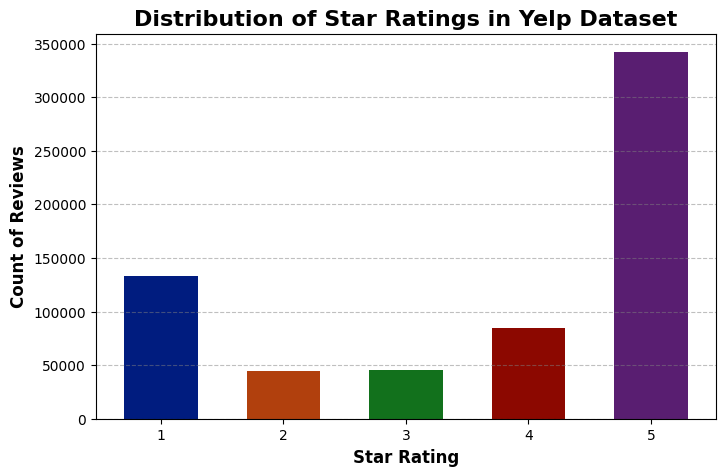

In [66]:
# Count the occurrences of each star rating
star_counts = df["stars"].value_counts().sort_index()

# Define color palette
colors = sns.color_palette("dark", len(star_counts))

# Create a bar plot
plt.figure(figsize=(8, 5))
plt.bar(star_counts.index, star_counts.values, color=colors, width=0.6)
plt.xlabel("Star Rating", fontsize=12, fontweight="bold", color="black")
plt.ylabel("Count of Reviews", fontsize=12, fontweight="bold", color="black")
plt.title("Distribution of Star Ratings in Yelp Dataset", fontsize=16, fontweight="bold", color="black")
plt.xticks(star_counts.index, fontsize=10, color="black")
plt.yticks(fontsize=10, color="black")
plt.grid(axis="y", linestyle="--", alpha=0.5, color="gray")

# Show the plot
plt.show()

In [67]:
df["stars"].value_counts()

stars
5.0    342060
1.0    133057
4.0     84414
3.0     45870
2.0     44453
Name: count, dtype: int64

#### Key Insights from Star Ratings
- **Highly Polarized Reviews:** Most reviews are either 5-star (342K) or 1-star (133K), showing extreme user experiences.
- **Positive Bias:** 5-star reviews dominate, indicating high customer satisfaction.
- **Negative Impact:** 1-star reviews are the second highest, suggesting a strong reaction to bad experiences.
- **Few Neutral Ratings:** 3-star and 2-star reviews are much lower, meaning users rarely leave moderate feedback.

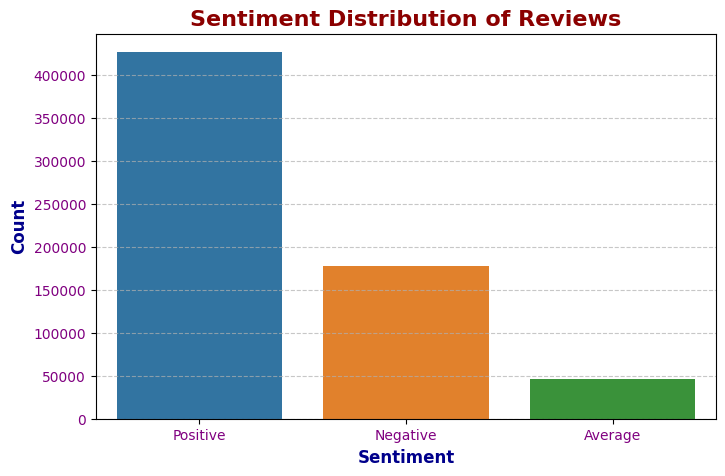

In [68]:
# Count sentiment distribution
sentiment_counts = df["sentiment"].value_counts()

# Define a color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)
plt.title("Sentiment Distribution of Reviews", fontsize=16, fontweight='bold', color='darkred')
plt.xlabel("Sentiment", fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel("Count", fontsize=12, fontweight='bold', color='darkblue')
plt.xticks(fontsize=10, color='purple')
plt.yticks(fontsize=10, color='purple')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [69]:
df["sentiment"].value_counts()

sentiment
Positive    426474
Negative    177510
Average      45870
Name: count, dtype: int64

- Positive Sentiment Dominates: 426,474 reviews (≈70%) are positive, indicating overall customer satisfaction.
- Significant Negative Feedback: 177,510 reviews (≈29%) are negative, showing a strong reaction to bad experiences.
- Few Neutral Reviews: Only 45,870 reviews (≈7%) are neutral, meaning users rarely leave middle-ground opinions

In [70]:
print("Minimum and Maximum values:")
print("Funny - Min:", df["funny"].min(), "Max:", df["funny"].max())
print("Useful - Min:", df["useful"].min(), "Max:", df["useful"].max())
print("Cool - Min:", df["cool"].min(), "Max:", df["cool"].max())

Minimum and Maximum values:
Funny - Min: 0 Max: 101
Useful - Min: 0 Max: 539
Cool - Min: 0 Max: 171


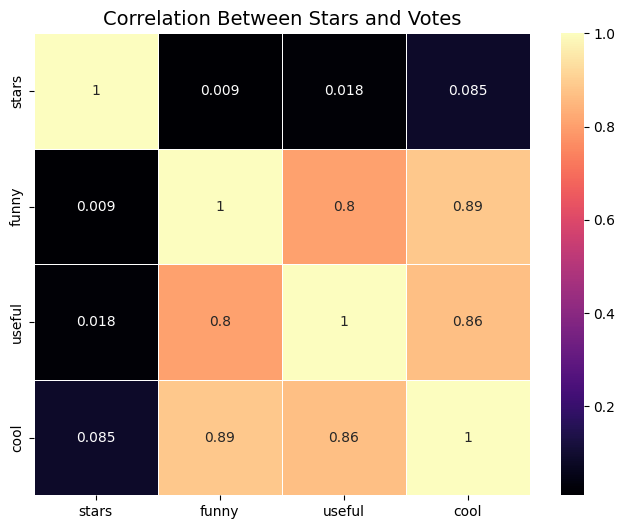

In [71]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[["stars", "funny", "useful", "cool"]].corr(), annot=True, cmap="magma", linewidths=0.5)
plt.title("Correlation Between Stars and Votes", fontsize=14)
plt.show()

In [72]:
# Compute correlation matrix
correlation_matrix = df[["stars", "funny", "useful", "cool"]].corr()

# Print correlation values
correlation_matrix

,stars,funny,useful,cool
stars,1.000000,0.009012,0.017659,0.084766
funny,0.009012,1.000000,0.803444,0.885260
useful,0.017659,0.803444,1.000000,0.864880
cool,0.084766,0.885260,0.864880,1.000000


- **Star ratings have almost no correlation with funny, useful, or cool votes.**
- **Funny and Cool votes are highly correlated (0.885)**—entertaining reviews are often seen as stylish.
- **Useful reviews tend to be both funny (0.803) and cool (0.865)**—well-written reviews get more engagement.
- **Businesses should focus on making reviews engaging and informative rather than just aiming for high-star ratings.**

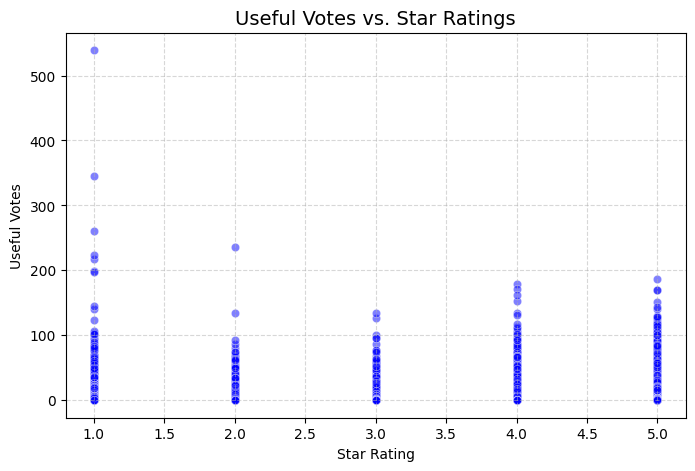

In [73]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["stars"], y=df["useful"], alpha=0.5, color="blue")
plt.title("Useful Votes vs. Star Ratings", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Useful Votes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [74]:
# Count total useful votes for each star rating
useful_counts = df.groupby("stars")["useful"].sum()

# Print the count of useful votes for each star rating
print(useful_counts)

stars
1.0     88947
2.0     31045
3.0     44364
4.0    118044
5.0    268393
Name: useful, dtype: int64


#### Insights from Useful Vote Counts Across Star Ratings
**5-Star Reviews Have the Most Useful Votes (268,393)**
- Highly rated reviews receive the most engagement.
- Positive experiences tend to be widely recognized as helpful.

**4-Star Reviews Also Have High Useful Votes (118,044)**
- Balanced reviews (not extreme) often provide detailed insights.

**1-Star Reviews Have Significant Useful Votes (88,947)**
- **Negative reviews often highlight issues or complaints that others find helpful.**

**2-Star Reviews Have the Lowest Useful Votes (31,045)**
- These may be less detailed or less noticed compared to extreme ratings.

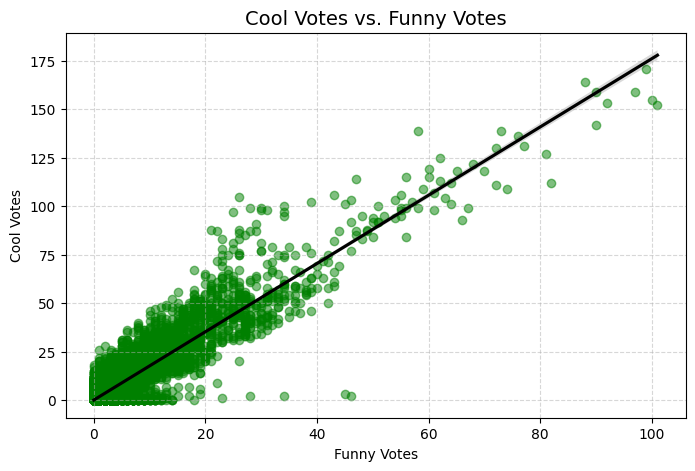

In [75]:
# Create scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=df["funny"], y=df["cool"], scatter_kws={"alpha": 0.5, "color": "green"}, line_kws={"color": "black"})

# Formatting the plot
plt.title("Cool Votes vs. Funny Votes", fontsize=14)
plt.xlabel("Funny Votes")
plt.ylabel("Cool Votes")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

The regression line in the plot clearly indicates a **strong relationship between funny and cool votes**, suggesting that reviews perceived as funny are also frequently considered cool.

#### WordCloud - for Positive and Negative Sentiment

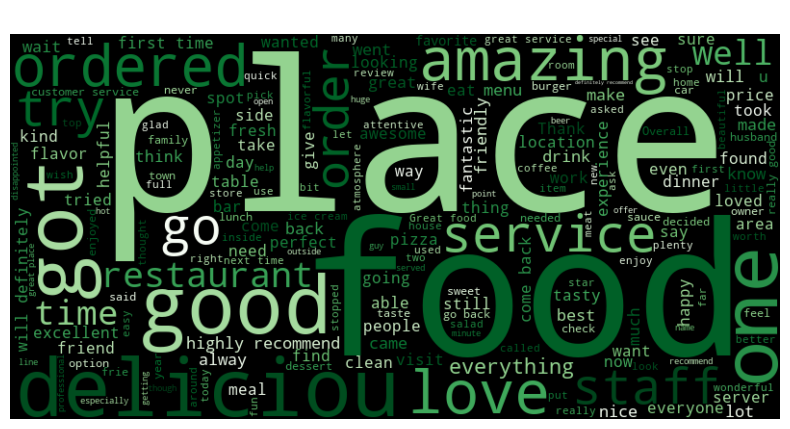

In [76]:
# Filter the dataset for positive sentiment reviews
positive_reviews = df[df["sentiment"] == "Positive"]["text"]

# Combine all positive reviews into a single string
positive_text = " ".join(review for review in positive_reviews)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Greens_r',  # Use 'Greens_r' for a darker green shade
    max_words=200
).generate(positive_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud for Positive Sentiment Reviews', fontsize=16, color='white')
plt.show()


**We see that, in the positive sentiment word cloud, we have words like 'delicious', 'amazing', 'love', 'good' etc.**


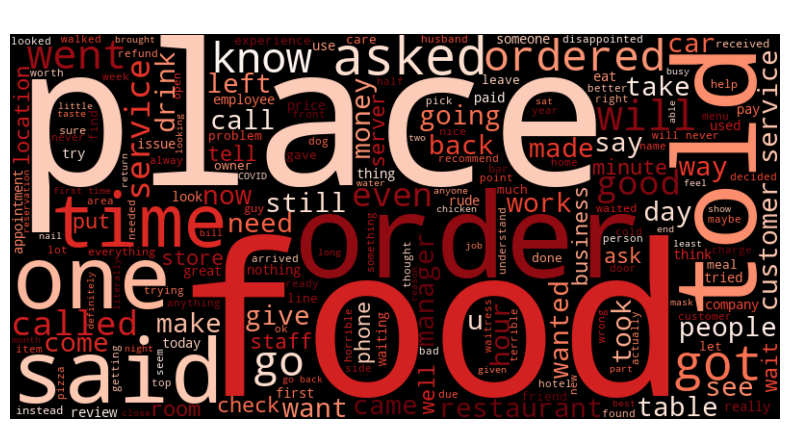

In [77]:
# Filter the dataset for negative sentiment reviews
negative_reviews = df[df["sentiment"] == "Negative"]["text"]

# Combine all negative reviews into a single string
negative_text = " ".join(review for review in negative_reviews)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='Reds_r',  # Use 'Reds_r' for a darker red shade
    max_words=200
).generate(negative_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud for Negative Sentiment Reviews', fontsize=16, color='white')
plt.show()

**We see that, in the negative sentiment word cloud, we have words like 'issue', 'rude', 'service', etc.**


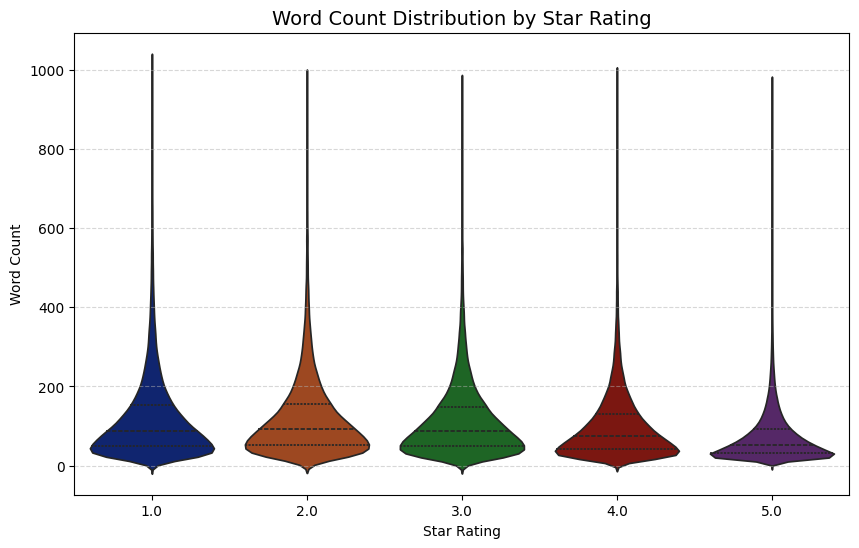

In [78]:
# Create a violin plot for word count distribution by star rating
plt.figure(figsize=(10, 6))
sns.violinplot(x=df["stars"], y=df["word_count"], palette="dark", inner="quartile")
plt.title("Word Count Distribution by Star Rating", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Word Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [79]:
# Compute word count statistics for each star rating
word_count_summary = df.groupby("stars")["word_count"].agg(["mean", "median", "min", "max"]).reset_index()

# Print word count distribution statistics by star rating
word_count_summary

,stars,mean,median,min,max
0,1.0,121.576753,87.0,1,1019
1,2.0,121.395339,92.0,6,976
2,3.0,114.931567,88.0,3,964
3,4.0,100.603289,75.0,4,988
4,5.0,74.385663,53.0,1,972


#### Insights from Word Count Distribution by Star Rating

##### Lower Star Ratings Have Longer Reviews  
- **1-star (Mean: 121.6) and 2-star (Mean: 121.4) reviews are the longest.**  
- **Negative experiences often lead to detailed complaints or rants.**

##### 5-Star Reviews Are the Shortest  
- **Mean: 74.4, Median: 53**  
- Satisfied customers tend to leave **short and positive** reviews.  
- Indicates **brevity in positive feedback**, whereas negative reviews require more explanation.  

##### Median Word Count Shows a Declining Trend  
- **1-star (87) → 2-star (92) → 3-star (88) → 4-star (75) → 5-star (53)**  
- As satisfaction increases, **review length decreases**.  

##### Outliers Exist Across All Ratings  
- Maximum word counts are consistently high (~1000 words across all ratings).  
- Some users leave **extremely long reviews**, regardless of sentiment.  

#### Trend of Average Word Count by Parts of the Day

In [80]:
# Define function to categorize time into parts of the day
def get_part_of_day(hour, minute):
    time_in_minutes = hour * 60 + minute  # Convert time to total minutes for easy comparison
    if 8 * 60 <= time_in_minutes < 12 * 60:
        return "Morning"
    elif 12 * 60 <= time_in_minutes < 14 * 60 + 30:
        return "Afternoon"
    elif 14 * 60 + 30 <= time_in_minutes < 19 * 60:
        return "Evening"
    elif 19 * 60 <= time_in_minutes < 24 * 60:
        return "Night"
    elif 0 <= time_in_minutes < 4 * 60:
        return "Midnight"
    else:
        return "Early Morning"

# Extract hour and minute from the date column
df["part_of_day"] = df["date"].apply(lambda x: get_part_of_day(x.hour, x.minute))

In [82]:
# Compute the average word count by part of the day
word_count_avg = df.groupby("part_of_day")["word_count"].mean()

# Ensure the index is in a proper order
word_count_avg = word_count_avg.reindex(["Midnight", "Early Morning", "Morning", "Afternoon", "Evening", "Night"])

# Print values for verification
print(word_count_avg)

part_of_day
Midnight          90.808172
Early Morning    101.533418
Morning          103.593270
Afternoon         99.552228
Evening           94.564996
Night             90.896418
Name: word_count, dtype: float64


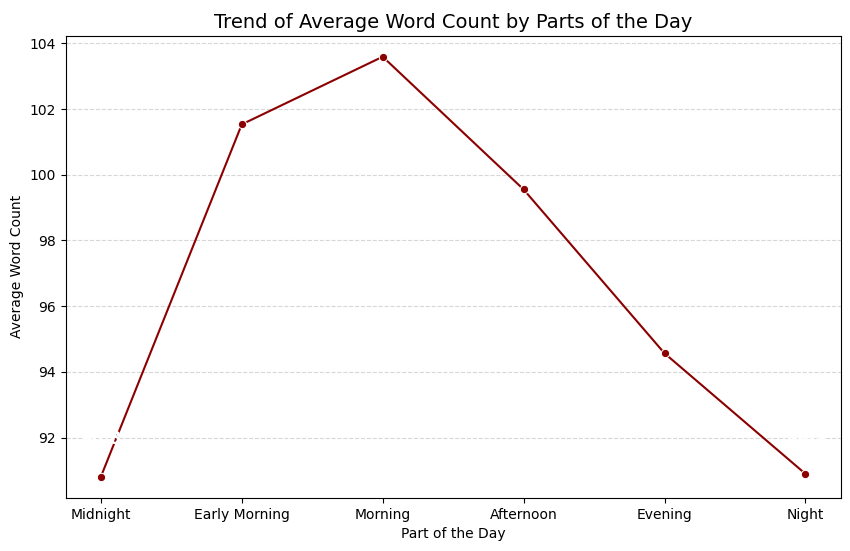

part_of_day
Midnight          90.808172
Early Morning    101.533418
Morning          103.593270
Afternoon         99.552228
Evening           94.564996
Night             90.896418
Name: word_count, dtype: float64


In [83]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=word_count_avg.index, y=word_count_avg.values, marker='o', linestyle='-', color='darkred')

# Add values on top of points
for i, value in enumerate(word_count_avg.values):
    plt.text(i, value + 1, f'{value:.1f}', ha='center', fontsize=12, color='white', fontweight='bold')

plt.title("Trend of Average Word Count by Parts of the Day", fontsize=14)
plt.xlabel("Part of the Day")
plt.ylabel("Average Word Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

print(word_count_avg)

##### Insights from Word Count by Part of the Day  

##### Morning & Early Morning Reviews Are the Longest  
- **Morning (103.59) and Early Morning (101.53) have the highest word counts.**  
- People writing in the **morning hours may be more detailed and expressive** in their reviews.  

##### Afternoon & Evening Reviews Are Slightly Shorter  
- **Afternoon (99.55) and Evening (94.56) reviews are slightly shorter** than morning ones.  
- Users might be writing reviews during breaks or in a rush, leading to **less detailed responses**.  

##### Night & Midnight Reviews Are the Shortest  
- **Night (90.89) and Midnight (90.80) reviews have the lowest word counts.**  
- Reviews written late at night may be **quick and to the point**, possibly due to fatigue or casual engagement.  

In [85]:
df_reviews = df[["text", "sentiment"]]

In [86]:
df_reviews.shape

(649854, 2)

In [87]:
df_reviews

,text,sentiment
0,I've been eating at this restaurant for over 5...,Positive
1,How does a delivery person from here get lost ...,Negative
2,I WISH I was still a Sierra resident. They're ...,Positive
3,"The service is always good, the employees are ...",Positive
4,two words: whipped. feta. \nexplosion of amazi...,Positive
...,...,...
649849,Great gym. Was in Indy for 4 days on business...,Positive
649850,It is very rare for a restaurant to be this go...,Positive
649851,We redesigned my moms dress and mad it complet...,Positive
649852,"This spot offers a great, affordable east week...",Positive


## Text Processing

This script performs text preprocessing using **Natural Language Processing (NLP)** techniques to clean and prepare Yelp reviews for sentiment classification.

#### Steps Involved:

1. **Define Important Sentiment Words**  
   - Retains key sentiment-related words like *"good"*, *"bad"*, *"amazing"*, *"disappointed"*.  
   - Removes other stopwords while keeping words essential for sentiment detection.  

2. **Text Cleaning & Preprocessing**  
   - Removes HTML tags using `BeautifulSoup()`.  
   - Removes punctuation & special characters using `re.sub()`.  
   - Converts text to lowercase to standardize.  
   - Tokenization & stopword removal using NLTK's stopword list.  
   - Lemmatization with `WordNetLemmatizer()` to reduce words to their root form (e.g., *"running"* → *"run"*).  

3. **Parallel Processing with Dask**  
   - Uses Dask DataFrame (`dd.from_pandas()`) to speed up text processing on large datasets.  
   - Applies `preprocess_text()` function across all reviews in parallel.  

4. **Convert Back to Pandas**  
   - The cleaned dataset is converted back to Pandas (`df_reviews_processed = df_dask.compute()`) for further analysis and model training.  

#### Why This Approach?
- Improves sentiment classification accuracy by removing noise.  
- Retains key sentiment words for meaningful feature extraction.  
- Parallel processing (`Dask`) speeds up execution for large datasets.  

This processed dataset is now ready for feature extraction (BoW, TF-IDF, Word Embeddings) and training ML models like Naïve Bayes, SVM, Logistic Regression, XGBoost, and LSTM.

In [88]:
# Define important sentiment words for Yelp reviews
important_words = {
    "not", "no", "never", "very", "good", "great", "best", "worst", "bad", "love", "hate", 
    "amazing", "awful", "delicious", "disgusting", "friendly", "rude", "helpful", "slow", 
    "fast", "expensive", "cheap", "clean", "dirty", "fresh", "stale", "perfect", "terrible", 
    "favorite", "horrible", "excellent", "poor", "fantastic", "overpriced", "underrated", 
    "recommend", "disappointed", "satisfied", "enjoyed", "waste", "worth", "cold", "hot", 
    "bland", "flavorful", "dry", "moist", "tough", "tender", "crispy", "soggy", "friendly", 
    "unfriendly", "attentive", "ignorant", "professional", "unprofessional", "polite", "impolite"
}

# Retain important words and remove all other stopwords
custom_stopwords = set(stopwords.words("english")) - important_words

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Define the text preprocessing function
def preprocess_text(text):
    try:
        # Remove HTML tags
        text = BeautifulSoup(text, "html.parser").get_text()
        # Remove punctuations and special characters
        text = re.sub(r"[^\w\s]", " ", text)
        # Tokenize and keep only alphabetic words
        words = text.split()
        words = [word for word in words if word.isalpha()]
        # Convert to lowercase
        words = [word.lower() for word in words]
        # Remove stopwords
        words = [word for word in words if word not in stop_words]
        # Apply lemmatization
        words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(words)
    except:
        return ""

# Load the DataFrame as a Dask DataFrame
df_dask = dd.from_pandas(df_reviews, npartitions=10)  # Adjust partitions for memory efficiency

# Apply preprocessing in parallel using Dask
df_dask["cleaned_text"] = df_dask["text"].map(preprocess_text, meta=("text", "str"))

# Compute the results and convert back to a Pandas DataFrame
df_reviews_processed = df_dask.compute()

In [89]:
df_reviews_processed

,text,sentiment,cleaned_text
0,I've been eating at this restaurant for over 5...,Positive,eating restaurant year staple ab family life r...
1,How does a delivery person from here get lost ...,Negative,delivery person get lost heard google map food...
2,I WISH I was still a Sierra resident. They're ...,Positive,wish still sierra resident definitely one best...
3,"The service is always good, the employees are ...",Positive,service always good employee nice vegan africa...
4,two words: whipped. feta. explosion of amazin...,Positive,two word whipped feta explosion amazingness hi...
...,...,...,...
649849,Great gym. Was in Indy for 4 days on business...,Positive,great gym indy day business local hotel gym me...
649850,It is very rare for a restaurant to be this go...,Positive,rare restaurant good category food ambience se...
649851,We redesigned my moms dress and mad it complet...,Positive,redesigned mom dress mad completely modern inc...
649852,"This spot offers a great, affordable east week...",Positive,spot offer great affordable east weekend paddl...


#### Text Vectorization for Sentiment Analysis

This script converts text data into numerical representations using **Bag of Words (BoW) and TF-IDF** for training machine learning models.

#### Steps Involved:

1. **Convert Sentiment Labels**  
   - Maps sentiment into three categories:  
     - Negative = 0  
     - Neutral (Average) = 1  
     - Positive = 2  

2. **Train-Test Split**  
   - Splits the dataset into **80% training** and **20% testing** while maintaining class balance (`stratify=y`).  

3. **Vectorization with BoW and TF-IDF**  
   - Uses `CountVectorizer` and `TfidfVectorizer` to convert text into numerical form.  
   - Limits vocabulary to the **5000 most frequent words** to reduce dimensionality.  

4. **Optimize Memory Usage**  
   - Converts vectorized data into **sparse matrices** (`csr_matrix`) for efficient storage and processing.  

5. **Print Matrix Shapes and Sample Features**  
   - Displays the shape of training and test datasets.  
   - Prints sample feature names from both BoW and TF-IDF representations.  

This processed data is now ready for training machine learning models such as Naïve Bayes, SVM, Logistic Regression, and XGBoost.

In [90]:
# Convert sentiment into three-class labels (Negative = 0, Neutral = 1, Positive = 2)
sentiment_mapping = {"Negative": 0, "Average": 1, "Positive": 2}
y = df_reviews_processed['sentiment'].map(sentiment_mapping)

# Split the data before applying vectorization (80% train, 20% test)
df_train, df_test, y_train, y_test = train_test_split(
    df_reviews_processed["cleaned_text"], y, test_size=0.2, random_state=42, stratify=y
)

# Initialize vectorizers with a vocabulary limit of 5000 most frequent words, optimized dtype
bow_vectorizer = CountVectorizer(max_features=5000, dtype=np.float32)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, dtype=np.float32)

# Apply vectorization only on the split dataset
X_train_bow = bow_vectorizer.fit_transform(df_train)
X_test_bow = bow_vectorizer.transform(df_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(df_train)
X_test_tfidf = tfidf_vectorizer.transform(df_test)

# Ensure matrices remain sparse to optimize memory
X_train_bow, X_test_bow = sp.csr_matrix(X_train_bow), sp.csr_matrix(X_test_bow)
X_train_tfidf, X_test_tfidf = sp.csr_matrix(X_train_tfidf), sp.csr_matrix(X_test_tfidf)

# Print matrix shapes
print("BoW Train Shape:", X_train_bow.shape, "Test Shape:", X_test_bow.shape)
print("TF-IDF Train Shape:", X_train_tfidf.shape, "Test Shape:", X_test_tfidf.shape)

# Print sample feature names
print("\nSample BOW feature names:", bow_vectorizer.get_feature_names_out()[:10])
print("Sample TF-IDF feature names:", tfidf_vectorizer.get_feature_names_out()[:10])

BoW Train Shape: (519883, 5000) Test Shape: (129971, 5000)
TF-IDF Train Shape: (519883, 5000) Test Shape: (129971, 5000)

Sample BOW feature names: ['aaa' 'ab' 'ability' 'able' 'absolute' 'absolutely' 'absurd' 'ac'
 'accent' 'accept']
Sample TF-IDF feature names: ['aaa' 'ab' 'ability' 'able' 'absolute' 'absolutely' 'absurd' 'ac'
 'accent' 'accept']


## Naïve Bayes

In [91]:
# Initialize Naïve Bayes classifiers for BoW and TF-IDF
nb_bow = MultinomialNB()
nb_tfidf = MultinomialNB()

# Train and predict on BoW features
nb_bow.fit(X_train_bow, y_train)
y_pred_bow = nb_bow.predict(X_test_bow)

# Train and predict on TF-IDF features
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Evaluate BoW Model
print("=" * 60)
print("Naïve Bayes - BoW Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

# Evaluate TF-IDF Model
print("\n" + "=" * 60)
print("Naïve Bayes - TF-IDF Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Naïve Bayes - BoW Results
Accuracy: 0.8148971693685515
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     35502
           1       0.28      0.52      0.37      9174
           2       0.95      0.87      0.91     85295

    accuracy                           0.81    129971
   macro avg       0.67      0.72      0.68    129971
weighted avg       0.85      0.81      0.83    129971


Naïve Bayes - TF-IDF Results
Accuracy: 0.8505512768232913
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     35502
           1       0.36      0.04      0.07      9174
           2       0.87      0.96      0.91     85295

    accuracy                           0.85    129971
   macro avg       0.68      0.60      0.60    129971
weighted avg       0.82      0.85      0.82    129971



## Support Vector Machine (SVM)

In [100]:
# Initialize SVM classifiers for BoW and TF-IDF with optimized parameters
svm_bow = LinearSVC(dual=False)  # dual=False is better for large datasets
svm_tfidf = LinearSVC(dual=False)

# Train and predict on BoW features
svm_bow.fit(X_train_bow, y_train)
y_pred_bow = svm_bow.predict(X_test_bow)

# Train and predict on TF-IDF features
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)

# Evaluate BoW Model
print("=" * 60)
print("SVM - BoW Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

# Evaluate TF-IDF Model
print("\n" + "=" * 60)
print("SVM - TF-IDF Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

SVM - BoW Results
Accuracy: 0.8946072585422902
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     35502
           1       0.53      0.14      0.22      9174
           2       0.92      0.97      0.95     85295

    accuracy                           0.89    129971
   macro avg       0.77      0.67      0.68    129971
weighted avg       0.88      0.89      0.88    129971


SVM - TF-IDF Results
Accuracy: 0.8984311884958952
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     35502
           1       0.57      0.14      0.22      9174
           2       0.93      0.97      0.95     85295

    accuracy                           0.90    129971
   macro avg       0.78      0.68      0.69    129971
weighted avg       0.88      0.90      0.88    129971



## Logistic Regression

In [93]:
# Initialize Logistic Regression classifiers for BoW and TF-IDF
logreg_bow = LogisticRegression(max_iter=1000, solver="lbfgs")  # lbfgs is robust for multiclass
logreg_tfidf = LogisticRegression(max_iter=1000, solver="lbfgs")

# Train and predict on BoW features
logreg_bow.fit(X_train_bow, y_train)
y_pred_bow = logreg_bow.predict(X_test_bow)

# Train and predict on TF-IDF features
logreg_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)

# Evaluate BoW Model
print("=" * 60)
print("Logistic Regression - BoW Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

# Evaluate TF-IDF Model
print("\n" + "=" * 60)
print("Logistic Regression - TF-IDF Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Logistic Regression - BoW Results
Accuracy: 0.8966153988197367
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     35502
           1       0.49      0.23      0.32      9174
           2       0.93      0.97      0.95     85295

    accuracy                           0.90    129971
   macro avg       0.76      0.70      0.72    129971
weighted avg       0.88      0.90      0.89    129971


Logistic Regression - TF-IDF Results
Accuracy: 0.8988774418908834
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     35502
           1       0.51      0.24      0.33      9174
           2       0.93      0.97      0.95     85295

    accuracy                           0.90    129971
   macro avg       0.77      0.70      0.72    129971
weighted avg       0.88      0.90      0.89    129971



## XGBoost

In [ ]:
# Initialize XGBoost classifiers with optimized hyperparameters
xgb_bow = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    objective="multi:softmax",  # Handles multi-class classification better
    num_class=3,  # If multi-class classification
    max_depth=6, 
    learning_rate=0.1, 
    n_estimators=300
)

xgb_tfidf = XGBClassifier(
    use_label_encoder=False, 
    eval_metric="logloss", 
    objective="multi:softmax",
    num_class=3,
    max_depth=6, 
    learning_rate=0.1, 
    n_estimators=300
)

# Train and predict on BoW features
xgb_bow.fit(X_train_bow, y_train)
y_pred_bow = xgb_bow.predict(X_test_bow)

# Train and predict on TF-IDF features
xgb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = xgb_tfidf.predict(X_test_tfidf)

# Evaluate BoW Model
print("=" * 60)
print("XGBoost - BoW Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

# Evaluate TF-IDF Model
print("\n" + "=" * 60)
print("XGBoost - TF-IDF Results")
print("=" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

XGBoost - BoW Results
Accuracy: 0.8788498972847789
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     35502
           1       0.51      0.16      0.25      9174
           2       0.90      0.97      0.93     85295

    accuracy                           0.88    129971
   macro avg       0.75      0.66      0.68    129971
weighted avg       0.86      0.88      0.86    129971


XGBoost - TF-IDF Results
Accuracy: 0.8809349778027407
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     35502
           1       0.51      0.17      0.25      9174
           2       0.90      0.97      0.93     85295

    accuracy                           0.88    129971
   macro avg       0.76      0.66      0.68    129971
weighted avg       0.86      0.88      0.86    129971



## RNN & LSTM

In [96]:
# Ensure raw text data is used for RNN/LSTM
X_train = df_train.tolist()  
X_test = df_test.tolist()

# Tokenize and pad text data
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # OOV token for unseen words
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Ensure consistency
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

# Label encoding and one-hot encoding
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

y_train_one_hot = to_categorical(y_train_num)
y_test_one_hot = to_categorical(y_test_num)

In [97]:
# Define the RNN model with Dropout for regularization
rnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.3),  # Helps prevent overfitting
    Dense(len(label_encoder.classes_), activation="softmax")
])

rnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train and evaluate RNN model
rnn_model.fit(X_train_pad, y_train_one_hot, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
rnn_predictions = rnn_model.predict(X_test_pad)
rnn_predictions = np.argmax(rnn_predictions, axis=1)  # Convert from one-hot to class labels

print("=" * 60)
print("RNN Model Results")
print("=" * 60)
print("RNN Accuracy:", accuracy_score(y_test_num, rnn_predictions))
print(classification_report(y_test_num, rnn_predictions))

Epoch 1/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 129s 17ms/step - accuracy: 0.6808 - loss: 0.7756 - val_accuracy: 0.8770 - val_loss: 0.3580
Epoch 2/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 851s 116ms/step - accuracy: 0.8809 - loss: 0.3509 - val_accuracy: 0.8893 - val_loss: 0.3141
Epoch 3/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step - accuracy: 0.8522 - loss: 0.4082 - val_accuracy: 0.6809 - val_loss: 0.7457
Epoch 4/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step - accuracy: 0.7779 - loss: 0.5640 - val_accuracy: 0.8696 - val_loss: 0.3823
Epoch 5/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 296s 40ms/step - accuracy: 0.8271 - loss: 0.4802 - val_accuracy: 0.6625 - val_loss: 0.7966
4062/4062 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
RNN Model Results
RNN Accuracy: 0.6623862246193382
              precision    recall  f1-score   support

           0       0.48      0.13      0.21     35502
           1       0.00      0.00      0.00      9174
           2       0.68      0.95      0.79     85295

    accuracy              

In [98]:
# Define the LSTM model with Dropout
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")
])

lstm_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train and evaluate LSTM model
lstm_model.fit(X_train_pad, y_train_one_hot, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
lstm_predictions = lstm_model.predict(X_test_pad)
lstm_predictions = np.argmax(lstm_predictions, axis=1)

print("\n" + "=" * 60)
print("LSTM Model Results")
print("=" * 60)
print("LSTM Accuracy:", accuracy_score(y_test_num, lstm_predictions))
print(classification_report(y_test_num, lstm_predictions))

Epoch 1/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 344s 47ms/step - accuracy: 0.7711 - loss: 0.6018 - val_accuracy: 0.8890 - val_loss: 0.2985
Epoch 2/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 344s 47ms/step - accuracy: 0.8923 - loss: 0.2956 - val_accuracy: 0.8997 - val_loss: 0.2668
Epoch 3/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 342s 47ms/step - accuracy: 0.9031 - loss: 0.2597 - val_accuracy: 0.9010 - val_loss: 0.2644
Epoch 4/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 347s 47ms/step - accuracy: 0.9095 - loss: 0.2407 - val_accuracy: 0.8997 - val_loss: 0.2682
Epoch 5/5
7311/7311 ━━━━━━━━━━━━━━━━━━━━ 362s 49ms/step - accuracy: 0.9150 - loss: 0.2246 - val_accuracy: 0.8978 - val_loss: 0.2772
4062/4062 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step

LSTM Model Results
LSTM Accuracy: 0.8978695247401344
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     35502
           1       0.46      0.36      0.40      9174
           2       0.94      0.96      0.95     85295

    accuracy            

## Model Comparison and Results

4062/4062 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
4062/4062 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step


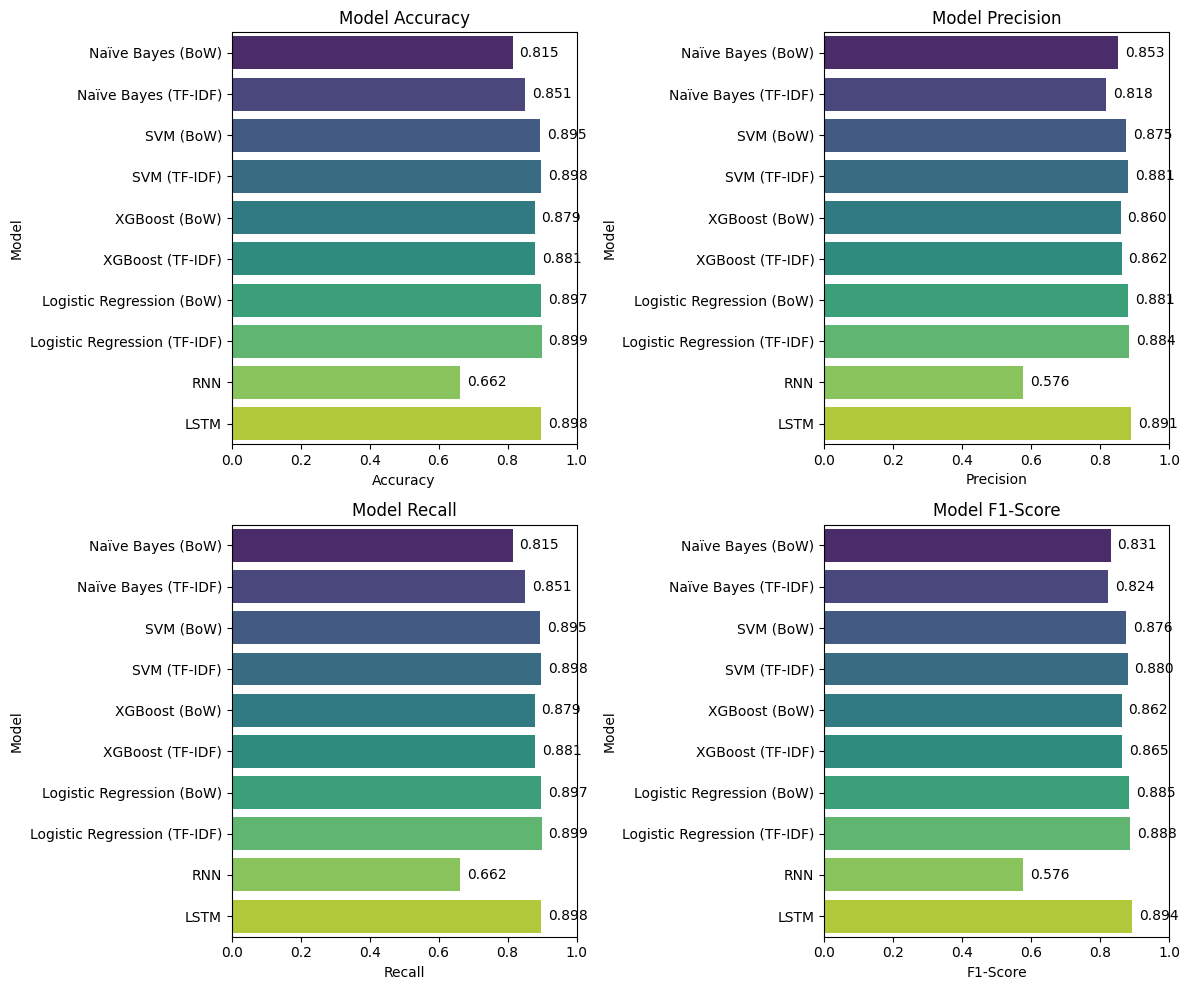

                              Accuracy  Precision    Recall  F1-Score
Model                                                                
Naïve Bayes (BoW)             0.814897   0.853315  0.814897  0.830504
Naïve Bayes (TF-IDF)          0.850551   0.818406  0.850551  0.823573
SVM (BoW)                     0.894607   0.875136  0.894607  0.875837
SVM (TF-IDF)                  0.898431   0.881214  0.898431  0.879758
XGBoost (BoW)                 0.878850   0.859962  0.878850  0.862320
XGBoost (TF-IDF)              0.880935   0.862362  0.880935  0.864692
Logistic Regression (BoW)     0.896615   0.881053  0.896615  0.885301
Logistic Regression (TF-IDF)  0.898877   0.884049  0.898877  0.887619
RNN                           0.662386   0.576282  0.662386  0.576399
LSTM                          0.897870   0.890817  0.897870  0.893887


In [102]:
# Generate predictions for all models
model_results = {
    "Naïve Bayes (BoW)": nb_bow.predict(X_test_bow),
    "Naïve Bayes (TF-IDF)": nb_tfidf.predict(X_test_tfidf),
    "SVM (BoW)": svm_bow.predict(X_test_bow),
    "SVM (TF-IDF)": svm_tfidf.predict(X_test_tfidf),
    "XGBoost (BoW)": xgb_bow.predict(X_test_bow),
    "XGBoost (TF-IDF)": xgb_tfidf.predict(X_test_tfidf),
    "Logistic Regression (BoW)": logreg_bow.predict(X_test_bow),
    "Logistic Regression (TF-IDF)": logreg_tfidf.predict(X_test_tfidf),
    "RNN": np.argmax(rnn_model.predict(X_test_pad), axis=1),  # Deep Learning Model
    "LSTM": np.argmax(lstm_model.predict(X_test_pad), axis=1)  # Deep Learning Model
}

# Convert results to DataFrame for visualization
df_results = pd.DataFrame([
    {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test if "RNN" not in model_name and "LSTM" not in model_name else y_test_num, y_pred),
        "Precision": classification_report(y_test if "RNN" not in model_name and "LSTM" not in model_name else y_test_num, y_pred, output_dict=True)["weighted avg"]["precision"],
        "Recall": classification_report(y_test if "RNN" not in model_name and "LSTM" not in model_name else y_test_num, y_pred, output_dict=True)["weighted avg"]["recall"],
        "F1-Score": classification_report(y_test if "RNN" not in model_name and "LSTM" not in model_name else y_test_num, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    }
    for model_name, y_pred in model_results.items()
])

# Set Model Names as Index
df_results.set_index("Model", inplace=True)

# Plot Performance Metrics with Values on Bars
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
titles = ["Model Accuracy", "Model Precision", "Model Recall", "Model F1-Score"]

for i, metric in enumerate(metrics):
    sns.barplot(y=df_results.index, x=df_results[metric], ax=ax[i//2, i%2], palette="viridis")

    # Add values inside bars with spacing for better visibility
    for index, value in enumerate(df_results[metric]):
        ax[i//2, i%2].text(value + 0.02, index, f"{value:.3f}", ha='left', va='center', fontsize=10, color="black")

    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].set_xlabel(metric)
    ax[i//2, i%2].set_xlim(0, 1)  # Ensures all bars have a similar range

plt.tight_layout()
plt.show()

# Print the results DataFrame
print(df_results)

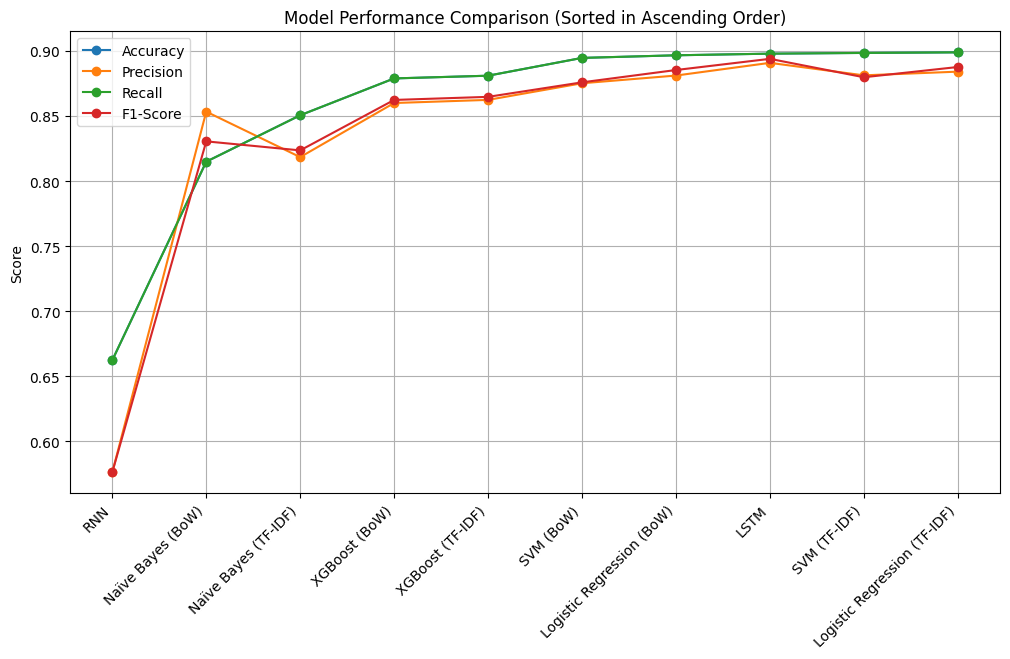

In [103]:
# Ensure df_results exists before plotting
if 'df_results' in globals():
    # Sort models in ascending order by Accuracy
    df_results_sorted = df_results.sort_values(by="Accuracy", ascending=True)

    plt.figure(figsize=(12, 6))

    for metric in ["Accuracy", "Precision", "Recall", "F1-Score"]:
        plt.plot(df_results_sorted.index, df_results_sorted[metric], marker='o', linestyle='-', label=metric)

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Score")
    plt.title("Model Performance Comparison (Sorted in Ascending Order)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("df_results is not defined. Please run the model evaluation first.")


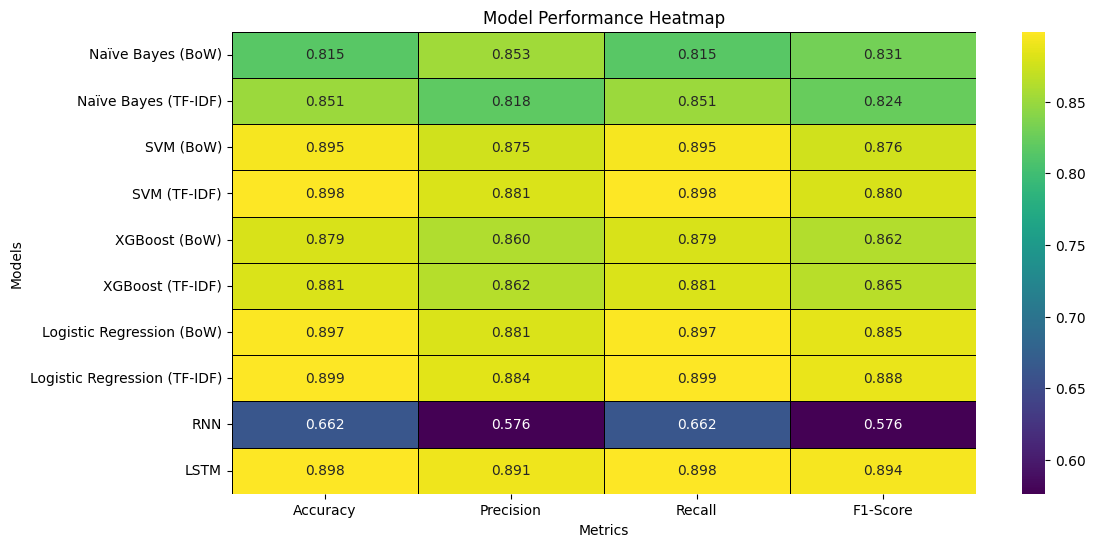

In [104]:
# Ensure df_results exists before plotting
if 'df_results' in globals():
    plt.figure(figsize=(12, 6))

    # Create a heatmap for better visualization of performance metrics
    sns.heatmap(df_results, annot=True, cmap="viridis", fmt=".3f", linewidths=0.5, linecolor="black")

    # Title and labels
    plt.title("Model Performance Heatmap")
    plt.xlabel("Metrics")
    plt.ylabel("Models")

    # Show the plot
    plt.show()
else:
    print("df_results is not defined. Please run the model evaluation first.")

In [114]:
# Save Logistic Regression Model (TF-IDF)
joblib.dump(logreg_tfidf, "logreg_tfidf_model.pkl")

# Save SVM Model (TF-IDF)
joblib.dump(svm_tfidf, "svm_tfidf_model.pkl")

# Save LSTM Model
best_lstm_model.save("lstm_model.h5")

print("All models have been saved successfully!")

All models have been saved successfully!


## Model Performance Analysis

This table compares the performance of different machine learning and deep learning models for sentiment analysis based on **Accuracy, Precision, Recall, and F1-Score**.

## Key Observations:

1. **Best Performing Models**  
   - **LSTM achieved the highest F1-Score (89.39%)** and an accuracy of **89.78%**, making it the most effective model for sentiment classification.
   - **Logistic Regression (TF-IDF) is the best traditional ML model with an accuracy of 89.88%**, showing strong performance in sentiment prediction.
   - **SVM (TF-IDF) is a close competitor with 89.84% accuracy**, confirming its effectiveness in handling text-based classification.

2. **Comparison Between ML and Deep Learning Models**  
   - **LSTM outperforms all models** due to its ability to capture long-term dependencies and context in text.  
   - **Logistic Regression (TF-IDF) remains the best computationally efficient model**, making it a great alternative for large-scale applications.  
   - **SVM (TF-IDF) performs very similarly to Logistic Regression**, making it another strong option.

3. **Performance of XGBoost**  
   - **XGBoost (TF-IDF) achieved an accuracy of 88.09%**, but it still falls behind traditional ML models like Logistic Regression and SVM.  
   - XGBoost can still be useful when combined with other models in an ensemble approach.

4. **Naïve Bayes Struggles**  
   - **Naïve Bayes (BoW) performed the worst among traditional models** with **81.48% accuracy**.  
   - **TF-IDF improves Naïve Bayes significantly (85.05%)**, but it remains less effective than other models.

5. **RNN Performed the Worst**  
   - **RNN had the lowest accuracy at 66.23%**, indicating its inability to handle complex sentiment patterns effectively.  
   - **Precision (57.62%) and F1-Score (57.63%)** show that it frequently misclassifies sentiment.

6. **TF-IDF Outperforms BoW Across All Models**  
   - **TF-IDF consistently improves performance**, showing that weighting words based on importance helps models capture sentiment better.

## Conclusion:
- **LSTM is the best overall model** but is computationally intensive.
- **Logistic Regression (TF-IDF) is the best traditional ML model**, offering high accuracy and efficiency.
- **SVM (TF-IDF) is also a strong alternative**, performing nearly as well as Logistic Regression.
- **XGBoost, while effective, does not surpass SVM or Logistic Regression.**
- **Naïve Bayes should not be used for multi-class sentiment analysis.**
- **RNN has the worst performance and should be avoided.**

## Final Model Selection:
For our **sentiment analysis moving forward**, we will use the **top 3 models**:
- **LSTM (Best Deep Learning Model)**  
- **Logistic Regression (TF-IDF) (Best ML Model)**  
- **SVM (TF-IDF) (Close ML Competitor)**  

These models will be used to **predict sentiment** in future analysis!


### Sentiment Prediction

This script uses the trained **LSTM model** to classify restaurant reviews into **Positive, Neutral, or Negative** sentiments. It **preprocesses input text**, tokenizes and pads sequences, and makes predictions based on the trained model. The output displays each review with its predicted sentiment.


In [ ]:
# Load the best performing deep learning model (assuming LSTM performed the best)
best_lstm_model = lstm_model  # If saved, use: best_lstm_model = load_model('lstm_model.h5')

# Define a function to preprocess input text for predictions
def preprocess_texts(texts, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    return padded_sequences

# Manually shuffled restaurant reviews (Alternating sentiment order)
sample_texts = [
    "Absolutely fantastic meal! Everything was cooked to perfection, and the flavors were incredible.",  # Positive
    "The food was okay, but nothing special. I expected more for the price.",  # Neutral
    "The worst burger I have ever had! The bun was stale, and the patty was overcooked.",  # Negative
    "The customer service was outstanding! Staff was friendly, attentive, and made great recommendations.",  # Positive
    "Had to wait a bit too long for my food. It was good but not worth the wait.",  # Neutral
    "Completely overpriced for the small portions they serve. Not worth it.",  # Negative
    "Loved the ambiance! The lighting and music created a perfect dining experience. Will visit again.",  # Positive
    "The decor was nice, but the food was just average. Might give it another try.",  # Neutral
    "The seafood was not fresh at all. It smelled bad, and I couldn't eat it.",  # Negative
    "The desserts were heavenly! The chocolate lava cake was rich and melted in my mouth.",  # Positive
    "Not the best experience, but not the worst either. A very average meal.",  # Neutral
    "Found a hair in my food. Absolutely disgusting! Will never come back.",  # Negative
    "One of the best steaks I've ever had! Juicy, tender, and seasoned perfectly.",  # Positive
    "Drinks were good, but the food was underwhelming. Maybe a better spot for cocktails than dinner.",  # Neutral
    "Had a reservation but still had to wait 45 minutes. Very unprofessional service!",  # Negative
    "Great portion sizes and affordable prices. The quality of ingredients was top-notch!",  # Positive
    "The pasta was decent, but I’ve had better. Needed more seasoning.",  # Neutral
    "The staff was rude and ignored our requests. Left without finishing my meal.",  # Negative
    "The chef came to our table to ask about our experience. Such a nice touch!",  # Positive
    "Service was a bit slow, but the staff was polite. The meal was decent overall.",  # Neutral
    "Terrible experience! The food was cold and took forever to arrive.",  # Negative
]

# Define sentiment labels
sentiment_labels = {0: "NEGATIVE REVIEW 😡 ❌", 1: "NEUTRAL REVIEW 😐", 2: "POSITIVE REVIEW 😊 ✅"}

# Predict with Logistic Regression (TF-IDF)
logreg_predictions = logreg_tfidf.predict(tfidf_vectorizer.transform(sample_texts))

# Predict with SVM (TF-IDF)
svm_predictions = svm_tfidf.predict(tfidf_vectorizer.transform(sample_texts))

# Preprocess input for LSTM
max_length = 100  # Adjust as per training data
X_test_pad = preprocess_texts(sample_texts, tokenizer, max_length)
lstm_predictions = best_lstm_model.predict(X_test_pad)
lstm_predicted_classes = np.argmax(lstm_predictions, axis=1)

# Print Predictions for all models
print("\n" + "=" * 80)
print("PREDICTIONS FROM TOP 3 MODELS")
print("=" * 80)

for i, text in enumerate(sample_texts):
    sentiment_logreg = sentiment_labels[logreg_predictions[i]]
    sentiment_svm = sentiment_labels[svm_predictions[i]]
    sentiment_lstm = sentiment_labels[lstm_predicted_classes[i]]

    print(f"🔹 **Text:** {text}")
    print(f"   📌 **Logistic Regression Prediction:** {sentiment_logreg}")
    print(f"   📌 **SVM Prediction:** {sentiment_svm}")
    print(f"   📌 **LSTM Prediction:** {sentiment_lstm}")
    print("=" * 80)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

PREDICTIONS FROM TOP 3 MODELS
🔹 **Text:** Absolutely fantastic meal! Everything was cooked to perfection, and the flavors were incredible.
   📌 **Logistic Regression Prediction:** POSITIVE REVIEW 😊 ✅
   📌 **SVM Prediction:** POSITIVE REVIEW 😊 ✅
   📌 **LSTM Prediction:** POSITIVE REVIEW 😊 ✅
🔹 **Text:** The food was okay, but nothing special. I expected more for the price.
   📌 **Logistic Regression Prediction:** NEUTRAL REVIEW 😐
   📌 **SVM Prediction:** NEUTRAL REVIEW 😐
   📌 **LSTM Prediction:** NEGATIVE REVIEW 😡 ❌
🔹 **Text:** The worst burger I have ever had! The bun was stale, and the patty was overcooked.
   📌 **Logistic Regression Prediction:** NEGATIVE REVIEW 😡 ❌
   📌 **SVM Prediction:** NEGATIVE REVIEW 😡 ❌
   📌 **LSTM Prediction:** NEGATIVE REVIEW 😡 ❌
🔹 **Text:** The customer service was outstanding! Staff was friendly, attentive, and made great recommendations.
   📌 **Logistic Regression Prediction:** POSITIVE REVIEW 😊 ✅
   📌 **SVM Predictio

### **Conclusion & Key Takeaways**

### **🔹 Overview**
The **sentiment analysis** was conducted using the top 3 performing models:  
📌**Logistic Regression (TF-IDF)**  
📌**SVM (TF-IDF)**  
📌**LSTM**  

Each model classified **positive, negative, and neutral** restaurant reviews. Below are the **key insights** based on the predictions.

### **🔹 Key Takeaways**

#### **📌 Logistic Regression and SVM Perform Similarly**
- Both **Logistic Regression (TF-IDF)** and **SVM (TF-IDF)** provided **consistent predictions**, especially for neutral reviews.
- They correctly identified **neutral** reviews in most cases (e.g., *"The food was okay, but nothing special."*).
- Their performance is nearly **identical**, making either a **strong choice for fast, reliable classification**.

#### **📌 LSTM Struggles with Neutral Reviews**
- **LSTM tends to misclassify neutral reviews as either positive or negative.**  
  - Example: *"The food was okay, but nothing special."*  
    - **Logistic Regression:** Neutral ✅  
    - **SVM:** Neutral ✅  
    - **LSTM:** ❌ **Negative**
  - Example: *"Service was a bit slow, but the staff was polite."*  
    - **Logistic Regression:** Neutral ✅  
    - **SVM:** Neutral ✅  
    - **LSTM:** ❌ **Positive**  
- This suggests **LSTM struggles with neutrality**, likely because deep learning models focus on **strong sentiment cues** rather than neutrality.

#### **📌 LSTM Excels in Capturing Strong Sentiments**
- LSTM **correctly classifies highly emotional reviews**, whether **positive or negative**.
- It identified **positive** sentiments like *"The customer service was outstanding!"* with **high confidence**.
- Similarly, it **accurately predicted** extreme **negative** reviews like *"Found a hair in my food. Absolutely disgusting!"*.

#### **📌 All Models Agree on Strongly Positive & Negative Reviews**
- **For highly opinionated reviews, all three models provide the same predictions.**
- Example: *"The worst burger I have ever had! The bun was stale, and the patty was overcooked."*  
  - ✅ **All models predicted Negative**
- Example: *"One of the best steaks I've ever had! Juicy, tender, and seasoned perfectly."*  
  - ✅ **All models predicted Positive**

#### **📌 Best Model for Practical Use**
- **If computational efficiency is needed →** ✅ **Logistic Regression (TF-IDF)**
- **If accuracy and stability are key →** ✅ **SVM (TF-IDF)**
- **If deep learning is preferred for more complex text understanding →** ✅ **LSTM**

#### **Final Recommendation**
📌 **For balanced sentiment classification**, we recommend using **SVM (TF-IDF)** or **Logistic Regression (TF-IDF)** as they handle **neutral reviews better** while maintaining **high accuracy**.  
📌 **For future improvements**, LSTM can be further fine-tuned or trained with **more neutral samples** to avoid bias towards strong sentiments.
